In [1]:
import pandas as pd
import torch
import numpy as np

# LRAP. Instance-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LRAP(preds, labels):
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = (scores.sum(-1) / labels.sum(-1)).mean()
    return score.item()

# label-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LWLRAP(preds, labels):
    preds = preds.to('cpu')
    labels = labels.to('cpu')

    labels[labels > 0.0] = 1.0  # label smoothingする場合もスコア計算のため1にしてしまう
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    # Number of GT labels per instance
    # num_labels = labels.sum(-1)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = scores.sum() / labels.sum()
    return score.item()

In [3]:

input_dir = "../oof/"
oof0 = pd.read_csv(input_dir + "fold0_oof.csv")
oof1 = pd.read_csv(input_dir + "fold1_oof.csv")
oof2 = pd.read_csv(input_dir + "fold2_oof.csv")
oof3 = pd.read_csv(input_dir + "fold3_oof.csv")
oof4 = pd.read_csv(input_dir + "fold4_oof.csv")
oof = pd.concat([oof0, oof1, oof2, oof3, oof4])
oof

,patch,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,0,005f1f9a5,0.419551,0.504427,0.484060,0.759330,0.377298,0.440424,0.445374,0.546310,...,0.507120,0.452462,0.468487,0.448512,0.455128,0.432421,0.446194,0.447356,0.311572,0.434605
1,1,005f1f9a5,0.396798,0.486966,0.469415,0.780136,0.366831,0.430549,0.448318,0.710311,...,0.481859,0.480372,0.448020,0.452117,0.478289,0.436401,0.442213,0.435832,0.363722,0.424249
2,2,005f1f9a5,0.403585,0.505900,0.466897,0.753976,0.388104,0.437647,0.445861,0.611135,...,0.496514,0.443103,0.445862,0.459949,0.467634,0.433311,0.446555,0.438964,0.383641,0.431579
3,3,005f1f9a5,0.402064,0.832450,0.463063,0.633777,0.405035,0.448586,0.441746,0.447559,...,0.471960,0.421197,0.450990,0.445003,0.513665,0.437371,0.440824,0.428674,0.328415,0.427762
4,4,005f1f9a5,0.403528,0.473602,0.468838,0.780878,0.381220,0.437699,0.448309,0.455435,...,0.495195,0.426309,0.455125,0.451277,0.499567,0.432191,0.439536,0.449185,0.311849,0.437247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7555,3,ffb8d8391,0.471341,0.518652,0.402118,0.785095,0.403647,0.427831,0.444437,0.538236,...,0.527225,0.461460,0.432797,0.438428,0.708003,0.443226,0.423604,0.511258,0.341249,0.462736
7556,4,ffb8d8391,0.467302,0.520136,0.415078,0.776820,0.411327,0.438416,0.446074,0.501656,...,0.593592,0.474326,0.434268,0.435380,0.667570,0.443391,0.431527,0.510715,0.346233,0.467822
7557,5,ffb8d8391,0.445331,0.495403,0.414823,0.761928,0.409735,0.560597,0.445686,0.469129,...,0.522081,0.462494,0.436113,0.437827,0.623461,0.434932,0.433658,0.484901,0.356306,0.395993
7558,6,ffb8d8391,0.430252,0.466971,0.436511,0.734888,0.451346,0.543858,0.449167,0.483951,...,0.462961,0.450826,0.461461,0.452139,0.712060,0.455197,0.432453,0.467728,0.369370,0.402045


In [6]:
oof2 = oof.groupby('recording_id').max().reset_index(drop=False)
oof2

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,00204008d,7,0.548896,0.520025,0.467474,0.697040,0.446893,0.448438,0.460121,0.584658,...,0.549394,0.461434,0.428925,0.460038,0.703318,0.463842,0.441076,0.479856,0.421455,0.480373
1,003b04435,7,0.454728,0.951329,0.904934,0.786413,0.456735,0.449087,0.466502,0.534860,...,0.548008,0.468029,0.426552,0.401656,0.518370,0.426427,0.442919,0.466933,0.244232,0.445347
2,003bec244,7,0.437407,0.695119,0.433345,0.765424,0.392101,0.439933,0.457725,0.656230,...,0.622062,0.505020,0.466320,0.447618,0.476920,0.430968,0.494836,0.460993,0.513579,0.520855
3,005f1f9a5,7,0.419551,0.832450,0.484060,0.788383,0.405035,0.448586,0.448318,0.831307,...,0.507120,0.483111,0.468487,0.459949,0.513665,0.444374,0.446555,0.449185,0.383641,0.437247
4,006ab765f,7,0.469207,0.421055,0.443135,0.604782,0.521481,0.451041,0.481147,0.451165,...,0.518086,0.469907,0.426772,0.475149,0.482384,0.442636,0.461442,0.483430,0.368766,0.927742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4722,ffc6031f8,7,0.413844,0.530123,0.443135,0.813791,0.400870,0.427655,0.432869,0.945660,...,0.504306,0.929942,0.424109,0.426820,0.480365,0.426354,0.461369,0.445122,0.447168,0.397644
4723,ffd88cd84,7,0.824914,0.837108,0.478534,0.726099,0.407227,0.440960,0.483977,0.434387,...,0.627796,0.957305,0.428378,0.426839,0.814257,0.425503,0.426070,0.459479,0.442835,0.455910
4724,ffebe7313,7,0.434797,0.477869,0.442087,0.550913,0.762544,0.425178,0.435173,0.487786,...,0.411168,0.497823,0.452318,0.445224,0.498972,0.437679,0.436377,0.967661,0.470680,0.472302
4725,fff163132,7,0.435145,0.485229,0.510467,0.633282,0.444803,0.456847,0.437899,0.527457,...,0.446378,0.429514,0.459516,0.471421,0.453194,0.458484,0.458985,0.478719,0.401862,0.463500


In [20]:
tp = pd.read_csv("../input/rfcx-species-audio-detection/train_tp.csv")
tp_fnames, tp_labels = [], []
for recording_id, df in tp.groupby("recording_id"):
    v = sum([np.eye(24)[i] for i in df["species_id"].tolist()])
    v = (v  == 1).astype(int).tolist()
    tp_fnames.append(recording_id)
    tp_labels.append(v) 

tp2 = pd.DataFrame(tp_labels, columns=[f's{i}' for i in range(24)])
tp2['recording_id'] = tp_fnames
tp2 = tp2.sort_values('recording_id')
tp2


,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s15,s16,s17,s18,s19,s20,s21,s22,s23,recording_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,003bec244
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,006ab765f
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,007f87ba2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0099c367b
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,009b760e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fe8d9ac40
1128,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fea6b438a
1129,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ff2eb9ce5
1130,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ffb8d8391


In [21]:
tp_oof = oof2[oof2['recording_id'].isin(tp2['recording_id'])].reset_index(drop=True).sort_values('recording_id')
tp_oof

,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,003bec244,7,0.437407,0.695119,0.433345,0.765424,0.392101,0.439933,0.457725,0.656230,...,0.622062,0.505020,0.466320,0.447618,0.476920,0.430968,0.494836,0.460993,0.513579,0.520855
1,006ab765f,7,0.469207,0.421055,0.443135,0.604782,0.521481,0.451041,0.481147,0.451165,...,0.518086,0.469907,0.426772,0.475149,0.482384,0.442636,0.461442,0.483430,0.368766,0.927742
2,007f87ba2,7,0.419532,0.502611,0.440387,0.872133,0.899028,0.456750,0.442422,0.464996,...,0.433639,0.451770,0.476786,0.417244,0.509499,0.438851,0.451265,0.480770,0.464247,0.449161
3,0099c367b,7,0.411238,0.438968,0.455962,0.538688,0.433760,0.456978,0.454956,0.497238,...,0.456046,0.551905,0.474548,0.750889,0.514071,0.460972,0.465610,0.453676,0.395555,0.451871
4,009b760e6,7,0.466158,0.464070,0.463557,0.583807,0.476545,0.449991,0.476532,0.520289,...,0.541122,0.485194,0.409296,0.464253,0.505128,0.459567,0.453548,0.555791,0.388502,0.621835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,fe8d9ac40,7,0.436519,0.505375,0.427869,0.714508,0.441814,0.458994,0.436955,0.473613,...,0.459438,0.432675,0.551637,0.462548,0.474333,0.466328,0.451010,0.456676,0.393870,0.470676
1128,fea6b438a,7,0.422376,0.439193,0.434108,0.849344,0.910174,0.452776,0.448938,0.480518,...,0.490813,0.443551,0.472011,0.465563,0.485953,0.435484,0.460873,0.763856,0.423832,0.466825
1129,ff2eb9ce5,7,0.976842,0.409023,0.440584,0.809126,0.467854,0.460264,0.444050,0.530747,...,0.457555,0.497049,0.445969,0.402109,0.919045,0.405408,0.450359,0.485972,0.415575,0.454400
1130,ffb8d8391,7,0.482317,0.582037,0.436511,0.819500,0.451346,0.560597,0.449167,0.538236,...,0.593592,0.478443,0.461461,0.452139,0.769213,0.455197,0.444676,0.517507,0.375439,0.467822


In [32]:
pred = tp_oof.loc[:, 's0':'s23'].values
target = tp2.loc[:, 's0':'s23'].values

In [39]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
auc = roc_auc_score(target, pred, average=None)
auc

array([0.9871719 , 0.95996303, 0.99259176, 0.7549353 , 0.96031423,
       0.96833641, 0.99707872, 0.94      , 0.98014787, 0.9909375 ,
       0.99473401, 0.9661183 , 0.9315342 , 0.99678373, 0.98245841,
       0.97100602, 0.99333435, 0.98342491, 0.9238817 , 0.99225843,
       0.97247429, 0.94955638, 0.9956133 , 0.94647101])

<BarContainer object of 24 artists>

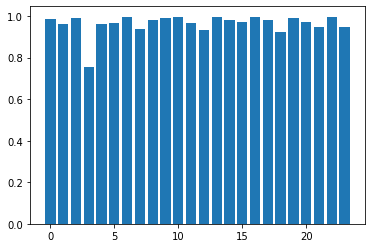

In [41]:
plt.bar(np.arange(24), auc)

In [30]:
pred = torch.tensor(pred)
target = torch.tensor(target)
pred.shape, target.shape

(torch.Size([1132, 24]), torch.Size([1132, 24]))

In [31]:
original_lwlrap = LWLRAP(pred, target)
original_lwlrap

0.7941980361938477